In [113]:
from hash_test import Node
from hash_test import HashTable
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
df = pd.read_excel("exampleOutputMIDRC.xlsx")
df.dropna(inplace = True) #Remove rows with empty entries
df.reset_index(inplace = True) #Reset index to sequential order
img_ids = list(df["uniqueID"])
h = HashTable()
h.init_table(img_ids)
imb_dict = {}
w_dict = {}
weights = []
numsamps = 0
samplesize = 0
try:
    numsamps = int(input("Number of samples: "))
    samplesize = int(input("Sample size: "))
except Exception:
    raise ValueError("Please enter integer values.")
imb_category = input("Choose variable to imbalance by. ")
try:
    imb_order = list(df[imb_category].unique())
    print("The unique entries for this category are: ", str(imb_order))
    imb_prop = input("In the same order that the unique entries appear, list proportions separated by commas. ").split(",")
    for i,val in enumerate(imb_prop):
        imb_prop[i] = float(val)
    if sum(imb_prop) != 1:
        raise Exception("Proportions do not add to 1.")
    if len(imb_order) != len(imb_prop):
        raise Exception("Unequal list sizes.")
    for i,prop in enumerate(imb_prop):
        cat_samples = round(prop * samplesize) #if prop * samplesize is a decimal, round
        imb_dict[imb_order[i]] = cat_samples
    print("The sample makeup is: ", imb_dict)
    weight_category = input("Weight by: ")
    if weight_category == imb_category:
        raise Exception("Weight and imbalance variables must be different.")
    w_order = list(df[weight_category].unique())
    freq = df[weight_category].value_counts()
    print("The unique entries for this category are: ", str(w_order))
    w_prop = input("In the same order that the unique entries appear, list proportions separated by commas. ").split(",")
    for i,val in enumerate(w_prop):
        w_prop[i] = float(val)
    if len(w_order) != len(w_prop):
        raise Exception("Unequal list sizes.")
    if abs(sum(w_prop) != 1):
        raise Exception("Proportions do not add to 1.")
except Exception:
    raise KeyError("Invalid Input")
indexes = {}
cat_prob = {}
sub_img = {}
for ind,val in enumerate(df[imb_category]):
    if val not in indexes:
        indexes[val] = [ind]
        sub_img[val] = [img_ids[ind]]
    else:
        indexes[val].append(ind)
        sub_img[val].append(img_ids[ind])
for key, lst in indexes.items():
    for idx in lst:
        if key not in cat_prob:
            cat_prob[key] = [w_prop[w_order.index(df[weight_category][idx])]/len(df.loc[(df[weight_category] == df[weight_category].iloc[idx]) & (df[imb_category] == df[imb_category].iloc[idx])])]
        else:
            cat_prob[key].append(w_prop[w_order.index(df[weight_category][idx])]/len(df.loc[(df[weight_category] == df[weight_category].iloc[idx]) & (df[imb_category] == df[imb_category].iloc[idx])]))
for cat in indexes:
    cat_prob[cat] = np.array(cat_prob[cat])
    cat_prob[cat] = cat_prob[cat] / cat_prob[cat].sum() #normalize each bucket
for samp_id in range(1,numsamps+1):
    for cat in imb_dict:
        samp = np.random.choice(sub_img[cat], imb_dict[cat], p = cat_prob[cat])
        for img in samp:
            h.insert(samp_id, img, sub_img[cat], cat_prob[cat])
inv_hash = h.invTable(numsamps)
inv_hash.print_hash_inv()
h.show_stats()

KeyboardInterrupt: Interrupted by user

In [29]:
df = pd.read_excel("exampleOutputMIDRC.xlsx")
df.loc[df["race"].isna() == True]

,uniqueID,sex,race,ethnic,result,predictionR
76,77,Male,NaN,Hispanic or Latino,0,0.5534


In [5]:
df

,index,uniqueID,sex,race,ethnic,result,predictionR
0,0,1,Male,Black/African-American,Not Hispanic or Latino,0,0.0087
1,1,2,Female,Black/African-American,Not Hispanic or Latino,0,0.8906
2,2,3,Female,Black/African-American,Not Hispanic or Latino,0,0.5903
3,3,4,Male,Black/African-American,Not Hispanic or Latino,1,0.5994
4,4,5,Male,Black/African-American,Not Hispanic or Latino,0,0.2010
...,...,...,...,...,...,...,...
1042,1043,1044,Female,Black/African-American,Not Hispanic or Latino,0,0.0117
1043,1044,1045,Female,Black/African-American,Not Hispanic or Latino,0,0.0643
1044,1045,1046,Male,Black/African-American,Not Hispanic or Latino,0,0.0315
1045,1046,1047,Male,Black/African-American,Not Hispanic or Latino,0,0.0771


In [104]:
# Calculating Load Factor Subsets - Run this after the running first cell
cat_1 = input("Enter the first variable that will be considered in load factor calculations. ")
cat_2 = input("Enter the second variable that will be considered in load factor calculations. ")
unique_lst_1 = None
unique_lst_2 = None
try:
    unique_lst_1 = list(df[cat_1].unique())
    unique_lst_2 = list(df[cat_2].unique())
except Exception:
    raise KeyError("Invalid variable.")
load_dict = {}
idx = 0
for img,node in h.table.items():
    var1 = df.loc[df["uniqueID"] == img][cat_1][idx]
    var2 = df.loc[df["uniqueID"] == img][cat_2][idx]
    idx += 1
    if var1 not in load_dict:
        lst = [1,0] #first element represents number of buckets, second element represnets number of nodes
        count = 0
        current = node
        while current != None:
            count += 1
            current = current.next
        lst[1] += count
        load_dict[var1] = {var2: lst}
    else:
        if var2 not in load_dict[var1]:
            lst = [1,0]
            count = 0
            current = node
            while current != None:
                count += 1
                current = current.next
            lst[1] += count
            load_dict[var1][var2] = lst
        else:
            load_dict[var1][var2][0] += 1
            count = 0
            current = node
            while current != None:
                count += 1
                current = current.next
            load_dict[var1][var2][1] += count

for cat_1 in load_dict:
    for cat_2 in load_dict[cat_1]:
        load_dict[cat_1][cat_2].append(load_dict[cat_1][cat_2][1]/load_dict[cat_1][cat_2][0])
print(load_dict)      

Enter the first variable that will be considered in load factor calculations. race
Enter the second variable that will be considered in load factor calculations. result
{'Black/African-American': {0: [778, 1021, 1.3123393316195373], 1: [110, 683, 6.209090909090909]}, 'White': {0: [84, 136, 1.619047619047619], 1: [10, 47, 4.7]}, 'More than one Race': {0: [37, 48, 1.2972972972972974], 1: [4, 22, 5.5]}, 'Native Hawaiian/Other Pacific Islander': {0: [1, 1, 1.0], 1: [1, 5, 5.0]}, 'Unknown': {0: [7, 9, 1.2857142857142858], 1: [2, 12, 6.0]}, 'American Indian or Alaska Native': {0: [4, 1, 0.25], 1: [1, 4, 4.0]}, 'Asian/Mideast Indian': {0: [6, 8, 1.3333333333333333]}, 'Patient Declined': {0: [2, 3, 1.5]}}


Enter weighting variable: modality
['DX' 'CR' 'CT' 'CT,CR' 'CR,DX' 'CT,CR,DX' 'CT,DX' 'MR,DX' 'MR' 'MR,CT,CR'
 'MR,CT,DX' 'MR,CT']
{'Yes': [2.7045454545454546, 0.40842105263157896, 1.105263157894737, 0.0, 0.0, 0.0, 0.0, 0.0, 49.666666666666664, 0.0, 0.0, 0.0], 'No': [1.2037037037037037, 0.10300820419325434, 3.8085106382978724, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Not Reported': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}


<AxesSubplot:>

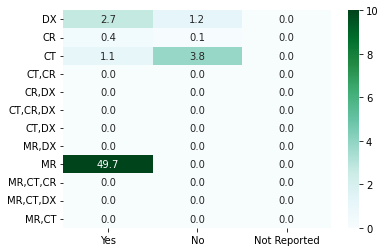

In [14]:
#After initializing load_dict - construct heatmaps
cat = input("Enter weighting variable: ")
unique = None
try:
    unique = df[cat].unique()
except:
    raise KeyError("Invaid input.")
print(unique)
out_dict = {}
for key in load_dict:
    sub_l = [0.0] * len(unique)
    count = 0 
    for idx,element in enumerate(unique):
        if element in load_dict[key]:
            sub_l[idx] = load_dict[key][element][2]
    out_dict[key] = sub_l
print(out_dict)
heat_df = pd.DataFrame(out_dict, index = unique)
sns.heatmap(heat_df, cmap = "BuGn", vmax = 10, vmin = 0, annot = True, fmt = ".1f")

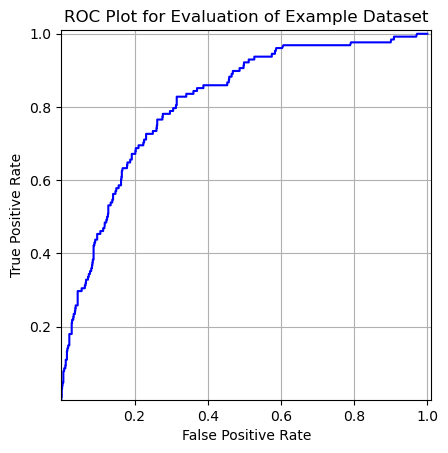

In [6]:
#Plot ROC curve of Entire Dataset
from sklearn import metrics
import matplotlib.pyplot as plt
df = pd.read_excel("exampleOutputMIDRC.xlsx")
eval_res = df["result"]
pred_rate = df["predictionR"]
fpr,tpr,thresholds = metrics.roc_curve(eval_res,pred_rate)
auc = metrics.auc(fpr,tpr)
plt.plot(fpr,tpr, label = "Entire Dataset (AUC = " + str(round(auc,2)) + ")", color = "blue")
plt.title("ROC Plot for Evaluation of Example Dataset")
plt.xticks(np.arange(0,1.1,0.2))
plt.yticks(np.arange(0,1.1,0.2))
plt.xlim([0.0001,1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.ylim([0.0001,1.01])
plt.grid()
plt.gca().set_aspect("equal")
plt.show()

Enter variable to plot ROCs by. sex


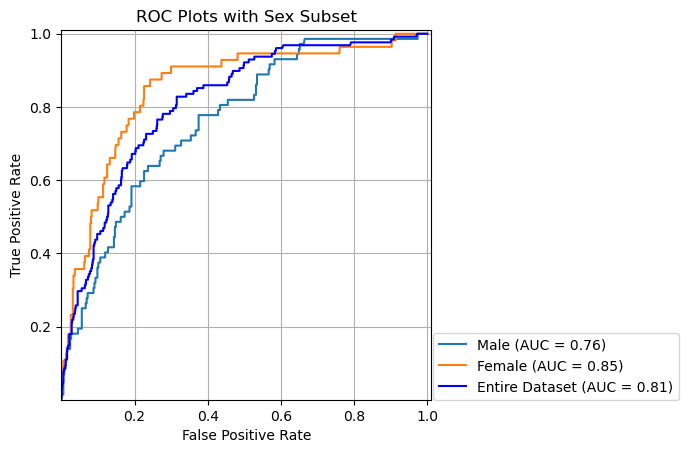

In [271]:
#Plot Many ROCs
def mult_ROC_strat():
    df = pd.read_excel("exampleOutputMIDRC.xlsx")
    strat = input("Enter variable to plot ROCs by. ")
    unique = set(df[strat].dropna())
    for i in unique:
        eval_res = df[df[strat] == i]["result"].reset_index()
        pred_rate = df[df[strat] == i]["predictionR"].reset_index()
        if 1 not in list(eval_res["result"]):
            continue
        fpr,tpr,thresholds = metrics.roc_curve(eval_res["result"],pred_rate["predictionR"])
        auc = metrics.auc(fpr,tpr)
        plt.plot(fpr,tpr,label = i + " (AUC = " + str(round(auc,2)) + ")")
        #disp = metrics.RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=auc)
    eval_res = df["result"]
    pred_rate = df["predictionR"]
    fpr,tpr,thresholds = metrics.roc_curve(eval_res,pred_rate)
    auc = metrics.auc(fpr,tpr)
    plt.plot(fpr,tpr, label = "Entire Dataset (AUC = " + str(round(auc,2)) + ")", color = "blue")
    plt.title("ROC Plots with " + strat.capitalize() + " Subset")
    plt.xticks(np.arange(0,1.1,0.2))
    plt.yticks(np.arange(0,1.1,0.2))
    plt.xlim([0.0001,1.01])
    plt.ylim([0.0001,1.01])
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend()
    plt.grid()
    plt.gca().set_aspect("equal")
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    plt.legend(bbox_to_anchor = (1.69,0.2))
    plt.show()  
mult_ROC_strat()

In [ ]:
"""
Previous Attempt at Correlating Load Factor and AUC
metric = input("Enter variable to conduct ROC analysis on. ")
res = input("Enter column name of result column.")
prediction = input("Enter column name of prediction column.")
if res == "":
    res = "result"
if prediction == "":
    prediction = "predictionR"
try:
    unique = set(df[metric].dropna())
    strat_dct = {}
    for strat in unique:
        strat_dct[strat] = []
except:
    raise Exception("Invalid Input")
ind = 0
for img_id in h.table:
    strat = df.loc[df["uniqueID"] == img_id][metric][ind]
    current = h.table[img_id]
    count = 0
    while current != None:
        count += 1
        current = current.next
    eval_res = [df.loc[df["uniqueID"] == img_id][res][ind]] * count
    pred_rate = [df.loc[df["uniqueID"] == img_id][prediction][ind]] * count
    if len(strat_dct[strat]) == 0:
        strat_dct[strat].append(eval_res)
        strat_dct[strat].append(pred_rate)
    else:
        strat_dct[strat][0] += eval_res
        strat_dct[strat][1] += pred_rate
    ind += 1
strata = []
aucs = []
lf = []
for strat in strat_dct:
    tot_eval_res = strat_dct[strat][0]
    tot_pred_rate = strat_dct[strat][1]
    if 1 not in tot_eval_res: #Omit strata that have no positives drawn
        continue
    fpr,tpr,thresholds = metrics.roc_curve(tot_eval_res,tot_pred_rate)
    strata.append(strat)
    aucs.append(metrics.auc(fpr,tpr))
    samp_count = 0
    total_count = 0
    for vals_lst in load_dict[strat].values():
        print(vals_lst)
        samp_count += vals_lst[1]
        total_count += vals_lst[0]
    lf.append(samp_count / total_count)
print(aucs)
print(lf)
"""

In [6]:
#Run this first before running next cell
def determineLoadFactors(numsamps, data_len, lfs):
    ssize_arr = []
    actual_lfs = []
    for lf in lfs:
        ssize_arr.append(round(lf * data_len / numsamps))
        actual_lfs.append(round(ssize_arr[-1] * numsamps / data_len,2))
    return (ssize_arr, actual_lfs)

In [7]:
def determineSampleSize(numsamps, data_len, lf):
    return (lf * data_len) / numsamps

In [102]:
def plotInterval(mean, lower, upper): #inspired by https://stackoverflow.com/questions/59747313/how-can-i-plot-a-confidence-interval-in-python 
    plt.plot([0.85,1.15], [lower,lower], color = "blue")
    plt.plot([0.85,1.15], [upper,upper], color = "blue")
    plt.plot([1,1], [lower,upper], color = "black")
    #plt.plot(1, mean, 'o', color = "orange")
    plt.xticks([])
    plt.xlim((0.25,1.75))
    plt.ylim((0,1))
    plt.show()

In [335]:
def HashTableThresholdOutPred(hashtable, threshold, numsamps, df, noise = 0.05, budget = 50000):
    if "predictionR" not in df.columns:
        raise Exception("Prediction entries absent from dataset")
    if "result" not in df.columns:
        raise Exception("Result entries absent from dataset")
    outputAUC = {}
    hinv = hashtable.invTable(numsamps)
    for sample in hinv.table:
        current = hinv.table[sample]
        if current == None:
            continue
        isfirst = True
        while current.next != None and budget > 0:
            if ((df[df["uniqueID"] == current.key]["result"].iloc[0] == 0 and abs(df[df["uniqueID"] == current.key]["predictionR"].iloc[0] - df[df["result"] == 0]["predictionR"].mean()) >= threshold) 
                or (df[df["uniqueID"] == current.key]["result"].iloc[0] == 1 and abs(df[df["uniqueID"] == current.key]["predictionR"].iloc[0] - df[df["result"] == 1]["predictionR"].mean()) >= threshold)):
                budget -= 1
                if isfirst: #Package into 3-tuples (img_id, original, new)
                    outputAUC[sample] = [(current.key, df[df["uniqueID"] == current.key]["predictionR"].iloc[0], df[df["uniqueID"] == current.key]["predictionR"].iloc[0] + abs(np.random.laplace(scale = 4 * noise)))]
                    isfirst = False
                else:
                    outputAUC[sample].append((current.key, df[df["uniqueID"] == current.key]["predictionR"].iloc[0], df[df["uniqueID"] == current.key]["predictionR"].iloc[0] + abs(np.random.laplace(scale = 4 * noise))))
            elif budget > 0:
                if isfirst:
                    outputAUC[sample] = [(current.key, df[df["uniqueID"] == current.key]["predictionR"].iloc[0], df[df["uniqueID"] == current.key]["predictionR"].iloc[0])]
                    isfirst = False
                else:
                    outputAUC[sample].append((current.key, df[df["uniqueID"] == current.key]["predictionR"].iloc[0], df[df["uniqueID"] == current.key]["predictionR"].iloc[0]))
            else:
                return outputAUC
            current = current.next
    print("Remaining Budget: " + str(budget))
    return outputAUC

In [27]:
#Initialize multthresholdAUC, call this before running next cell
mult_threshAUCs = {}

In [402]:
def HashTableThresholdOutAUC(hashtable, threshold, numsamps, df, noise = 0.1, budget = 100):
    eval_res_w = df["result"]
    pred_rate_w = df["predictionR"]
    fpr_w,tpr_w,thresholds_w = metrics.roc_curve(eval_res_w,pred_rate_w)
    auc_w = metrics.auc(fpr_w,tpr_w)
    if "predictionR" not in df.columns:
        raise Exception("Prediction entries absent from dataset")
    if "result" not in df.columns:
        raise Exception("Result entries absent from dataset")
    output_aucs = {}
    hinv = hashtable.invTable(numsamps)
    for sample in hinv.table:
        eval_res = []
        pred_rate = []
        current = hinv.table[sample]
        if budget <= 0:
            return output_aucs
        while current.next != None and budget > 0:
            eval_res.append(df[df["uniqueID"] == current.key]["result"])
            pred_rate.append(df[df["uniqueID"] == current.key]["predictionR"])
            current = current.next
        fpr, tpr, thresholds = metrics.roc_curve(eval_res, pred_rate)
        output_aucs[sample] = metrics.auc(fpr, tpr)
    for sample in hinv.table:
        if output_aucs[sample] - auc_w > threshold:
            output_aucs[sample] = (output_aucs[sample] + np.random.laplace(scale = 4 * noise), output_aucs[sample])
            budget -= 1
        else:
            output_aucs[sample] = (output_aucs[sample], output_aucs[sample])
    print("Budget Remaining: " + str(budget), end = "\n")
    return output_aucs

df = pd.read_excel("exampleOutputMIDRC.xlsx")
auc_IQRs = [] #For use in subsequent line graph
df.dropna(inplace = True) #Remove rows with empty entries
df.reset_index(inplace = True) #Reset index to sequential order
img_ids = list(df["uniqueID"])
lfs_input = input("Enter desired load factors, separated by commas. ")
lfs = lfs_input.split(",")
if lfs_input == "":
    lfs = []
    for i in np.arange(10,220,20): #Change LF factors here or input manually
        lfs.append(i)
for i,lf_str in enumerate(lfs):
    lfs[i] = float(lf_str)
numsamps = int(input("Number of samples: "))
info = determineLoadFactors(numsamps, len(df), lfs)
ssize_arr = info[0]
actual_lfs = info[1]
print(actual_lfs)
threshAUCs = {}
try:
    imb_category = input("Choose variable to imbalance by. ")
    imb_order = list(df[imb_category].unique())
    print("The unique entries for this category are: ", str(imb_order))
    imb_prop = input("In the same order that the unique entries appear, list proportions separated by commas. ").split(",")
    for i,val in enumerate(imb_prop):
        imb_prop[i] = float(val)
    if sum(imb_prop) != 1:
        raise Exception("Proportions do not add to 1.")
    if len(imb_order) != len(imb_prop):
        raise Exception("Unequal list sizes.")
    weight_category = input("Weight by: ")
    if weight_category == imb_category:
        raise Exception("Weight and imbalance variables must be different.")
    w_order = list(df[weight_category].unique())
    print("The unique entries for this category are: ", str(w_order))
    w_prop = input("In the same order that the unique entries appear, list proportions separated by commas. ").split(",")
    threshold = float(input("Input threshold:"))
    if threshold < 0 or threshold > 1:
        raise Exception("Threshold should be between 0 and 1")
    restart_mult = input("Clear mult_threshAUCs? [y for yes, no otherwise]")
    if restart_mult == "y":
        mult_threshAUCs = {}
    for i,val in enumerate(w_prop):
        w_prop[i] = float(val)
    if len(w_order) != len(w_prop):
        raise Exception("Unequal list sizes.")
    if abs(sum(w_prop) != 1):
        raise Exception("Proportions do not add to 1.")
    indexes = {}
    cat_prob = {}
    sub_img = {}
    for ind,val in enumerate(df[imb_category]):
        if val not in indexes:
            indexes[val] = [ind]
            sub_img[val] = [img_ids[ind]]
        else:
            indexes[val].append(ind)
            sub_img[val].append(img_ids[ind])
    for key, lst in indexes.items():
        for idx in lst:
            if key not in cat_prob:
                cat_prob[key] = [w_prop[w_order.index(df[weight_category][idx])]/len(df.loc[(df[weight_category] == df[weight_category].iloc[idx]) & (df[imb_category] == df[imb_category].iloc[idx])])]
            else:
                cat_prob[key].append(w_prop[w_order.index(df[weight_category][idx])]/len(df.loc[(df[weight_category] == df[weight_category].iloc[idx]) & (df[imb_category] == df[imb_category].iloc[idx])]))
    for cat in indexes:
        cat_prob[cat] = np.array(cat_prob[cat])
        cat_prob[cat] = cat_prob[cat] / cat_prob[cat].sum() #normalize each bucket
except Exception:
    raise KeyError("Invalid Input.")
lfs_ind = 0
for ssize in ssize_arr:
    print("Sample size: " + str(ssize))
    h = HashTable()
    h.init_table(img_ids)
    imb_dict = {}
    for i,prop in enumerate(imb_prop):
        cat_samples = round(prop * ssize) #if prop * samplesize is a decimal, round
        imb_dict[imb_order[i]] = cat_samples
    for samp_id in range(1,numsamps+1):
        for cat in imb_dict:
            samp = np.random.choice(sub_img[cat], imb_dict[cat], p = cat_prob[cat])
            for img in samp:
                #h.insert(samp_id, img, sub_img[cat], cat_prob[cat])
                h.insert_with_replacement(samp_id, img)
    #h.print_hash()
    h.show_stats()
    threshAUCs[lfs[lfs_ind]] = HashTableThresholdOutAUC(h, threshold, numsamps, df)
    mult_threshAUCs[threshold] = threshAUCs 
    lfs_ind += 1
    print("\n")

Enter desired load factors, separated by commas.  10,30,50,70
Number of samples:  100


[10.03, 29.99, 50.05, 70.01]


Choose variable to imbalance by.  result


The unique entries for this category are:  [0, 1]


In the same order that the unique entries appear, list proportions separated by commas.  0.3,0.7
Weight by:  sex


The unique entries for this category are:  ['Male', 'Female']


In the same order that the unique entries appear, list proportions separated by commas.  0.4,0.6
Input threshold: 0.03
Clear mult_threshAUCs? [y for yes, no otherwise] y


Sample size: 105
Nodes: 10600
Keys: 1047
Load Factor: 10.124164278892072
Longest Chain: 98 at keys [607, 904]
HashTable Inverted? False
Budget Remaining: 63


Sample size: 314
Nodes: 31400
Keys: 1047
Load Factor: 29.990448901623687
Longest Chain: 264 at keys [243]
HashTable Inverted? False
Budget Remaining: 81


Sample size: 524
Nodes: 52400
Keys: 1047
Load Factor: 50.04775549188157
Longest Chain: 433 at keys [857]
HashTable Inverted? False
Budget Remaining: 85


Sample size: 733
Nodes: 73300
Keys: 1047
Load Factor: 70.0095510983763
Longest Chain: 622 at keys [923]
HashTable Inverted? False
Budget Remaining: 92




In [395]:
def calcBudgetThreshold(noiserate, lf, nimages, nsamps):
    #numer = (noiserate ** 5) * ((lf * nimages)/nsamps) ** 2
    numer = (noiserate ** 5) * (((lf * nimages)/nsamps) ** 2)
    #denumer = 512 * np.log(8/(np.exp(-2 * (noiserate ** 2) * (lf * nimages)/nsamps)))
    denumer = 512 * (np.log(8) + 2 * (noiserate ** 2) * (lf * nimages)/nsamps)
    return numer/denumer

In [396]:
def calcNonOverFitProbability(noiserate, lf, nimages, nsamps):
    return 1 - np.exp(-2 * (noiserate ** 2) * (lf * nimages)/nsamps)

In [400]:
lfs = np.arange(0,10000,1)
nimages = len(df)
nsamps = int(input("Enter number of samples: "))
noiserate = float(input("Enter noiserate: " ))
budget = []
for lf in lfs:
    budget.append(calcBudgetThreshold(noiserate, lf, nimages, nsamps))
print(budget)

KeyboardInterrupt: Interrupted by user

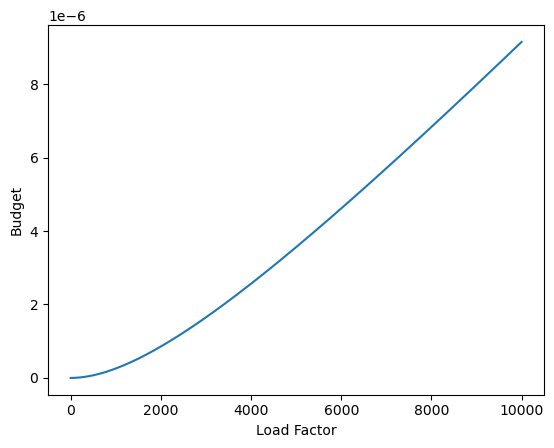

In [398]:
plt.plot(lfs, budget)
plt.xlabel("Load Factor")
plt.ylabel("Budget")
plt.savefig("/home/dylantang/Desktop/lfbudget.png")

In [385]:
lfs = np.arange(0,5000,200)
nimages = len(df)
nsamps = int(input("Enter number of samples: "))
noiserate = float(input("Enter noiserate: " ))
budget = []
for lf in lfs:
    budget.append(calcNonOverFitProbability(noiserate, lf, nimages, nsamps))
print(budget)

Enter number of samples:  100
Enter noiserate:  0.005


[0.0, 0.09940533953830322, 0.18892925754788115, 0.26955402009091767, 0.3421642507381686, 0.407556636753975, 0.46644867043466043, 0.5194865215112163, 0.567252126993125, 0.6102695762438519, 0.6490108613457386, 0.6839010558479219, 0.7153229787190585, 0.7436213946782433, 0.7691067969906091, 0.792058814232844, 0.8127292784080256, 0.8313449880734588, 0.8481101967988532, 0.8632088542584693, 0.8768066245467396, 0.8890527038625406, 0.9000814575059415, 0.9100138941487358, 0.9189589935546103]


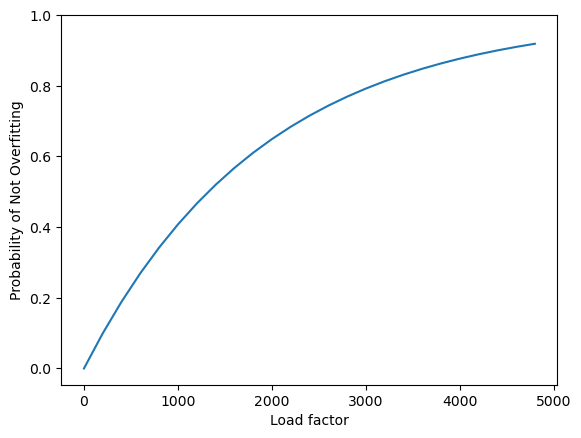

In [386]:
plt.plot(lfs, budget)
plt.yticks(np.arange(0,1.1,0.2))
plt.ylabel("Probability of Not Overfitting")
plt.xlabel("Load factor")
plt.savefig("/home/dylantang/Desktop/lfprobrelat.png")
plt.show()

Enter desired load factor in threshAUCs. ThreshAUCs: [10.0, 30.0, 50.0, 70.0] 10


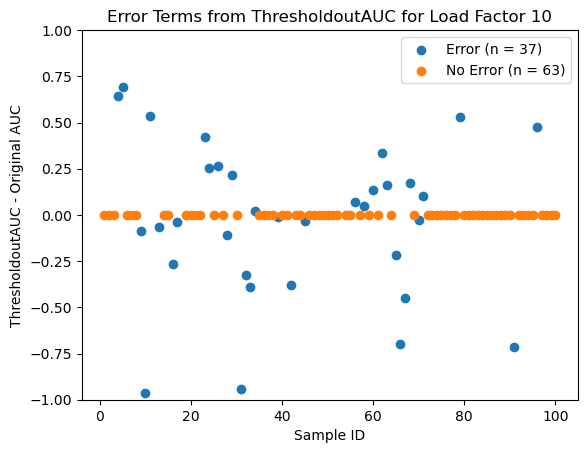

In [406]:
inputlf = int(input("Enter desired load factor in threshAUCs. ThreshAUCs: " + str(list(threshAUCs.keys()))))
#samplelf = int(input("Enter desired sample in threshAUCs. Min sampleID: " + str(min(threshAUCs[inputlf])) + " Max sampleID: " + str(max(threshAUCs[inputlf])) + " "))
if inputlf not in threshAUCs:
    raise Exception("Load factor is not in threshAUCs.")
#if samplelf not in threshAUCs[inputlf]:
    #raise Exception("Sample is not in threshAUCs at load factor " + str(inputlf))
samp_id_a = []
original_a = []
new_a = []
samp_id_u = []
original_u = []
new_u = []
for samp_id in threshAUCs[inputlf]:
    new_AUC,old_AUC = threshAUCs[inputlf][samp_id]
    if new_AUC - old_AUC != 0:
        samp_id_a.append(samp_id)
        original_a.append(old_AUC)
        new_a.append(new_AUC)
    else:
        samp_id_u.append(samp_id)
        original_u.append(old_AUC)
        new_u.append(new_AUC)
plt.scatter(samp_id_a, np.array(new_a) - np.array(original_a), label = "Error (n = " + str(len(new_a)) + ")")
plt.scatter(samp_id_u, np.array(new_u) - np.array(original_u), label = "No Error (n = " + str(len(new_u)) + ")")
plt.legend(bbox_to_anchor = (1,1))
plt.title("Error Terms from ThresholdoutAUC for Load Factor " + str(inputlf))
plt.xlabel("Sample ID")
plt.ylabel("ThresholdoutAUC - Original AUC")
#plt.ylim([-0.2,0.2])
plt.ylim([-1,1])
plt.savefig("/home/dylantang/Desktop/lf" + str(inputlf) + ".png")
plt.show()

[0.005, 0.01, 0.03, 0.05, 0.1]
[[0.59, 0.54, 0.57, 0.57], [0.48, 0.49, 0.49, 0.48], [0.35, 0.12, 0.1, 0.08], [0.15, 0.05, 0.03, 0.0], [0.03, 0.0, 0.0, 0.0]]
dict_keys([10.0, 30.0, 50.0, 70.0])


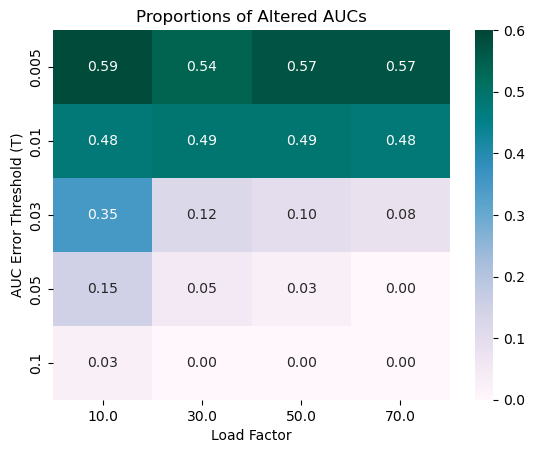

In [239]:
#Constructing heatmaps
idx = list(mult_threshAUCs.keys())
idx.sort()
props = []
for thresh in idx:
    props_lf = []
    for lf in mult_threshAUCs[thresh]:
        count = 0
        for sample_ids in mult_threshAUCs[thresh][lf]:
            new_AUC, old_AUC = mult_threshAUCs[thresh][lf][sample_ids]
            if new_AUC - old_AUC != 0:
                count += 1
        props_lf.append(count/len(mult_threshAUCs[thresh][lf]))
    props.append(props_lf)
print(idx)
print(props)
print(threshAUCs.keys())
df_input = pd.DataFrame(props, index = idx, columns = list(threshAUCs.keys()))
ax = sns.heatmap(df_input, cmap = "PuBuGn", vmax = 0.6, vmin = 0, annot = True, fmt = ".2f")
plt.title("Proportions of Altered AUCs")
plt.xlabel("Load Factor")
plt.ylabel("AUC Error Threshold (T)")
plt.savefig("/home/dylantang/Desktop/lfheatmap")

In [124]:
df = pd.read_excel("exampleOutputMIDRC.xlsx")
auc_IQRs = [] #For use in subsequent line graph
df.dropna(inplace = True) #Remove rows with empty entries
df.reset_index(inplace = True) #Reset index to sequential order
img_ids = list(df["uniqueID"])
lfs_input = input("Enter desired load factors, separated by commas. ")
lfs = lfs_input.split(",")
expected_adm = []
actual_adm = []
expected_inadm = []
actual_inadm = []
adm_diff = []
inadm_diff = []
if lfs_input == "":
    lfs = []
    for i in np.arange(10,220,20): #Change LF factors here or input manually
        lfs.append(i)
for i,lf_str in enumerate(lfs):
    lfs[i] = float(lf_str)
numsamps = int(input("Number of samples: "))
info = determineLoadFactors(numsamps, len(df), lfs)
ssize_arr = info[0]
actual_lfs = info[1]
print(actual_lfs)
#print(info)
try:
    imb_category = input("Choose variable to imbalance by. ")
    imb_order = list(df[imb_category].unique())
    print("The unique entries for this category are: ", str(imb_order))
    imb_prop = input("In the same order that the unique entries appear, list proportions separated by commas. ").split(",")
    for i,val in enumerate(imb_prop):
        imb_prop[i] = float(val)
    if sum(imb_prop) != 1:
        raise Exception("Proportions do not add to 1.")
    if len(imb_order) != len(imb_prop):
        raise Exception("Unequal list sizes.")
    weight_category = input("Weight by: ")
    if weight_category == imb_category:
        raise Exception("Weight and imbalance variables must be different.")
    w_order = list(df[weight_category].unique())
    print("The unique entries for this category are: ", str(w_order))
    w_prop = input("In the same order that the unique entries appear, list proportions separated by commas. ").split(",")
    for i,val in enumerate(w_prop):
        w_prop[i] = float(val)
    if len(w_order) != len(w_prop):
        raise Exception("Unequal list sizes.")
    if abs(sum(w_prop) != 1):
        raise Exception("Proportions do not add to 1.")
    oversamp_status = input("Calculate oversampling? [y for yes]: ")
    indexes = {}
    cat_prob = {}
    sub_img = {}
    for ind,val in enumerate(df[imb_category]):
        if val not in indexes:
            indexes[val] = [ind]
            sub_img[val] = [img_ids[ind]]
        else:
            indexes[val].append(ind)
            sub_img[val].append(img_ids[ind])
    for key, lst in indexes.items():
        for idx in lst:
            if key not in cat_prob:
                cat_prob[key] = [w_prop[w_order.index(df[weight_category][idx])]/len(df.loc[(df[weight_category] == df[weight_category].iloc[idx]) & (df[imb_category] == df[imb_category].iloc[idx])])]
            else:
                cat_prob[key].append(w_prop[w_order.index(df[weight_category][idx])]/len(df.loc[(df[weight_category] == df[weight_category].iloc[idx]) & (df[imb_category] == df[imb_category].iloc[idx])]))
    for cat in indexes:
        cat_prob[cat] = np.array(cat_prob[cat])
        cat_prob[cat] = cat_prob[cat] / cat_prob[cat].sum() #normalize each bucket
except Exception:
    raise KeyError("Invalid Input.")
all_aucs = []
for ssize in ssize_arr:
    h = HashTable()
    h.init_table(img_ids)
    imb_dict = {}
    for i,prop in enumerate(imb_prop):
        cat_samples = round(prop * ssize) #if prop * samplesize is a decimal, round
        imb_dict[imb_order[i]] = cat_samples
    for samp_id in range(1,numsamps+1):
        for cat in imb_dict:
            samp = np.random.choice(sub_img[cat], imb_dict[cat], p = cat_prob[cat])
            for img in samp:
                #h.insert(samp_id, img, sub_img[cat], cat_prob[cat])
                h.insert_with_replacement(samp_id, img)
    inv_hash = h.invTable(numsamps)
    aucs = []
    if oversamp_status == "y" and imb_category == "result": #Oversampling currenly only works for result imbalances
        adm_diff_count = 0
        inadm_diff_count = 0
        expected_adm.append([])
        actual_adm.append([])
        expected_inadm.append([])
        actual_inadm.append([])
        expected_adm_len = ssize * imb_prop[1] * numsamps / len(df.loc[df["result"] == 1])
        expected_inadm_len = ssize * imb_prop[0] * numsamps / len(df.loc[df["result"] == 0])
        index = 0
        for img in h.table.keys():
            actual_count = 0
            current = h.table[img]
            while current != None:
                actual_count += 1
                current = current.next
            if df["result"].iloc[index] == 1:
                expected_adm[-1].append(expected_adm_len)
                actual_adm[-1].append(actual_count)
                expected_inadm[-1].append(0)
                actual_inadm[-1].append(0)
            else:
                expected_inadm[-1].append(expected_inadm_len)
                actual_inadm[-1].append(actual_count)
                expected_adm[-1].append(0)
                actual_adm[-1].append(0) #Slight discrepancy between sum of actual_adm sublists and expected_adm sublists due to imbalance rounding
            if actual_adm[-1][-1] - expected_adm[-1][-1] > 0:
                adm_diff_count += actual_adm[-1][-1] - expected_adm[-1][-1]
            if actual_inadm[-1][-1] - expected_inadm[-1][-1] > 0: #only test for oversampling:
                inadm_diff_count += actual_inadm[-1][-1] - expected_inadm[-1][-1]
            index += 1
        adm_diff.append(adm_diff_count)
        inadm_diff.append(inadm_diff_count)
    for samp in inv_hash.table.keys():
        imgs = []
        res_arr = []
        pred_arr = []
        current = inv_hash.table[samp]
        while current != None:
            imgs.append(current)
            current = current.next
        for img in imgs:
            res_arr.append(df.loc[df["uniqueID"] == img.key].iloc[0]["result"])
            pred_arr.append(df.loc[df["uniqueID"] == img.key].iloc[0]["predictionR"])
        if 1 not in res_arr or 0 not in res_arr:
            continue
        fpr,tpr,thresholds = metrics.roc_curve(res_arr,pred_arr)
        aucs.append(metrics.auc(fpr,tpr))
    auc_IQRs.append(np.percentile(aucs, 75) - np.percentile(aucs, 25))
    all_aucs.append(aucs)
bootstrap_stat = input("A Posteriori Bootstrapping? ('y' if yes, any other key for no) ")
if bootstrap_stat != "y":
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    fig, ax = plt.subplots()
    plt.boxplot(all_aucs, widths = 0.25, positions = actual_lfs, manage_ticks = False)
    plt.xticks(np.arange(0.5,5.1,0.5), fontsize = 12)
    plt.yticks(np.arange(0,1.1,0.2), fontsize = 12)
    plt.xlabel("Load Factor", fontsize = 15)
    plt.ylabel("AUC", fontsize = 15)
    plt.title("Prevalence = " + str(imb_prop[1]), fontsize = 17)
    #plt.title("Load Factor with Respect to AUC", fontsize = 17)
    eval_res = df["result"]
    pred_rate = df["predictionR"]
    fpr,tpr,thresholds = metrics.roc_curve(eval_res,pred_rate)
    auc = metrics.auc(fpr,tpr)
    plt.axhline(auc, xmin = 0, xmax = 5, color = "blue", label = "AUC of Entire Dataset")
    plt.legend()
    ax2 = ax.twiny() #Dual Axes
    ssize_arr_str = []
    for ssize in ssize_arr:
        ssize_arr_str.append(str(ssize))
    left_x,right_x = ax.get_xlim()
    ax2.set_xlim(left_x, right_x)
    ax2.set_xticks(actual_lfs)
    ax2.set_xticklabels(ssize_arr_str, fontsize = 12)
    ax2.set_xlabel("Draw Size", fontsize = 15)
else:
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    fig, ax = plt.subplots()
    plt.boxplot(all_aucs, widths = 10, positions = actual_lfs, manage_ticks = False, showfliers = False)
    plt.xticks(np.arange(10,220,20), fontsize = 12)
    plt.yticks(np.arange(0,1.1,0.2), fontsize = 12)
    plt.xlabel("Load Factor", fontsize = 15)
    plt.ylabel("AUC", fontsize = 15)
    plt.title("Prevalence = " + str(imb_prop[1]), fontsize = 17)
    #plt.title("Load Factor with Respect to AUC", fontsize = 17)
    auc_arr = []
    for permute in range(1000): #A Posteriori Bootstrapping
        print("Permutation #:", permute)
        samps = np.random.choice(df["uniqueID"], 200)
        res_arr = []
        pred_arr = []
        for samp in samps:
            res_arr.append(int(df.loc[df["uniqueID"] == samp]["result"]))
            pred_arr.append(float(df.loc[df["uniqueID"] == samp]["predictionR"]))
        if 1 not in res_arr or 0 not in res_arr:
            continue
        fpr,tpr,thresholds = metrics.roc_curve(res_arr,pred_arr)
        auc_arr.append(metrics.auc(fpr,tpr))
    auc_arr = np.array(auc_arr)
    lower = np.percentile(auc_arr,2.5)
    mean = np.mean(auc_arr)
    median = np.median(auc_arr)
    upper = np.percentile(auc_arr,97.5)
    eval_res = df["result"]
    pred_rate = df["predictionR"]
    #fpr,tpr,thresholds = metrics.roc_curve(eval_res,pred_rate)
    #auc = metrics.auc(fpr,tpr)
    #plt.axhline(auc, xmin = 0, xmax = 5, color = "red", label = "AUC of Entire Dataset")
    plt.axhline(lower, xmin = 0, xmax = 5, linestyle = "--", color = "blue")
    plt.axhline(upper, xmin = 0, xmax = 5, linestyle = "--", color = "blue", label = "95% CI")
    plt.axhline(median, xmin = 0, xmax = 5, linestyle = "-.", color = "green", label = "Median")
    plt.legend() 
    ax2 = ax.twiny() #Dual Axes
    ssize_arr_str = []
    for ssize in ssize_arr:
        ssize_arr_str.append(str(ssize))
    left_x,right_x = ax.get_xlim()
    ax2.set_xlim(left_x, right_x)
    ax2.set_xticks(actual_lfs)
    ax2.set_xticklabels(ssize_arr_str)
    ax2.set_xlabel("Size of Test Subset", fontsize = 15)
plt.show()
if oversamp_status == "y":
    actual_lfs.insert(0,0)
    inadm_diff.insert(0,0)
    adm_diff.insert(0,0)
    fig, ax = plt.subplots()
    ax.set_xticks(lfs)
    ax.set_xlim(left = 0)
    plt.plot(actual_lfs, inadm_diff, color = "blue", label = "ICU Inadmission")
    plt.plot(actual_lfs, adm_diff, color = "red", label = "ICU Admission")
    actual_lfs.pop(0)
    plt.legend()
    ax.set_xlabel("Load Factor")
    ax.set_ylabel("Sum of Oversampled Image Selections")
    ax.set_ylim(bottom = 0)
    ax2 = ax.twiny()
    ssize_arr_str = []
    for ssize in ssize_arr:
        ssize_arr_str.append(str(ssize))
    ax2.set_xticks(actual_lfs)
    ax2.set_xticklabels(ssize_arr_str)
    ax2.set_xlabel("Size of Test Subset")
    plt.show()

Enter desired load factors, separated by commas.  10,30,50,70
Number of samples:  100


[10.03, 29.99, 50.05, 70.01]


KeyboardInterrupt: Interrupted by user

In [269]:
#A Posteriori Bootstrapping Interval Plot
df = pd.read_excel("exampleOutputMIDRC.xlsx")
df.dropna(inplace = True) #Remove rows with empty entries
df.reset_index(inplace = True) #Reset index to sequential order
auc_arr = []
for permute in range(500):
    print(permute)
    samps = np.random.choice(df["uniqueID"], 50)
    res_arr = []
    pred_arr = []
    for samp in samps:
        res_arr.append(int(df.loc[df["uniqueID"] == samp]["result"]))
        pred_arr.append(float(df.loc[df["uniqueID"] == samp]["predictionR"]))
    if 1 not in res_arr or 0 not in res_arr:
        continue
    fpr,tpr,thresholds = metrics.roc_curve(res_arr,pred_arr)
    auc_arr.append(metrics.auc(fpr,tpr))
auc_arr = np.array(auc_arr)
lower = np.percentile(auc_arr,25)
mean = np.mean(auc_arr)
upper = np.percentile(auc_arr,75)
plotInterval(mean, lower, upper)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108


KeyboardInterrupt: 

In [189]:
def calcAUCstDev(auc, lf, nimgs, nsamples, imb_ICU):
    first = auc * (1 - auc) + (((lf * nimgs)/nsamples) * imb_ICU - 1) * ((auc / (2 - auc)) - auc ** 2)
    second = ((lf * nimgs)/nsamples - ((lf * nimgs)/nsamples) * imb_ICU - 1) * (2 * auc ** 2 / (1 + auc) - auc ** 2)
    third = ((lf * nimgs)/nsamples * imb_ICU) * ((lf * nimgs)/nsamples - (lf * nimgs)/nsamples * imb_ICU)
    return ((first + second) / third) ** (1/2)

In [118]:
auc_IQRs_saved = auc_IQRs
actual_lfs_saved = actual_lfs

In [113]:
#Only run this for first simulation - works off saved copy
auc_IQRs_saved_list = [auc_IQRs_saved]
actual_lfs_saved_list = [actual_lfs_saved]
print(len(auc_IQRs_saved_list[0]))
print(len(actual_lfs_saved_list[0]))

21
21


In [119]:
numsimulations = int(input("Number of saved simulations: "))
confirm = input("Confirm? [y/n]")
if confirm != "y":
    raise Exception("Stopped execution.")
auc_IQRs_saved_list.append(auc_IQRs)
actual_lfs_saved_list.append(actual_lfs)
auc_IQRs_saved_list2 = []
actual_lfs_saved_list2 = []
#auc_IQRs_saved_list2 = np.array(auc_IQRs_saved_list2)
#auc_IQRs_saved_list2 = np.unique(auc_IQRs_saved_list2)
for i in range(0,numsimulations, 1):
    auc_IQRs_saved_list2.append(auc_IQRs_saved_list[i])
    actual_lfs_saved_list2.append(actual_lfs_saved_list[i])
for i in range(len(auc_IQRs_saved_list)-1,numsimulations-1,-1):
    auc_IQRs_saved_list.pop(-1)
    actual_lfs_saved_list.pop(-1)
print(len(auc_IQRs_saved_list2[0]))
print(len(actual_lfs_saved_list2[0]))

Number of saved simulations: 2
Confirm? [y/n]y
21
21


In [116]:
print(len(auc_IQRs_saved_list2[0]))
print(len(actual_lfs_saved_list2[0]))

21
21


Number of samples: 100


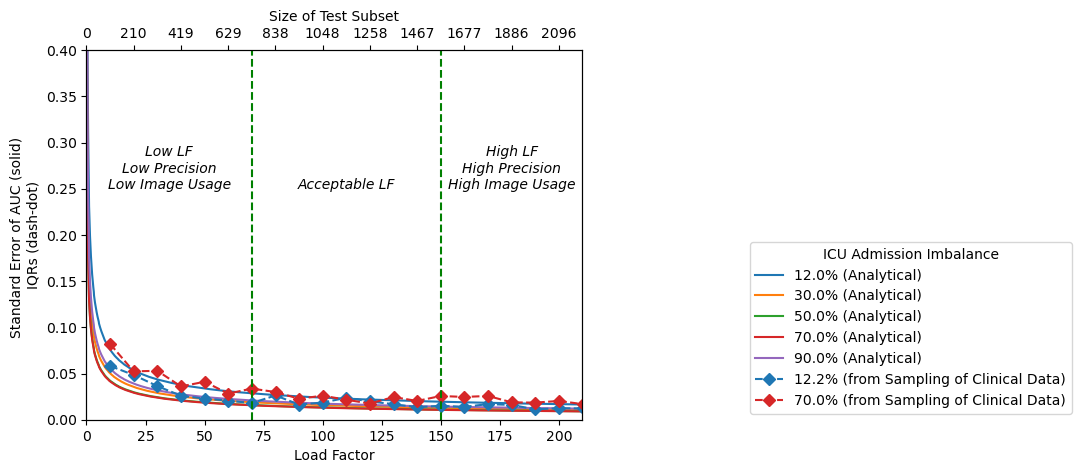

In [141]:
#Multiple Line Plots
df = pd.read_excel("exampleOutputMIDRC.xlsx")
eval_res = df["result"]
pred_rate = df["predictionR"]
fpr,tpr,thresholds = metrics.roc_curve(eval_res,pred_rate)
auc = metrics.auc(fpr,tpr)
lfs = np.arange(0.1,220,0.1)
numsamps = int(input("Number of samples: "))
ICU_imbs = np.arange(0.3,0.9,0.2)
ICU_imbs = np.insert(ICU_imbs, 0, 0.12)
#ICU_imbs = np.insert(ICU_imbs, 0, 0.05)
info = determineLoadFactors(numsamps, len(df), lfs)
ssize_arr = info[0]
actual_lfs = info[1]
stDev_AUCs = []
for i,_ in enumerate(ICU_imbs):
    stDev_AUCs.append([])
    for j,_ in enumerate(ssize_arr):
        stDev_AUCs[-1].append(calcAUCstDev(auc, actual_lfs[j], len(df), numsamps, ICU_imbs[i]))
fig, ax = plt.subplots()
#fig.set_figwidth(15)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
for i,stDev_AUC in enumerate(stDev_AUCs):
    plt.plot(lfs, stDev_AUC, label = str(round(ICU_imbs[i] * 100, 1)) + "%" + " (Analytical)")
plt.plot(actual_lfs_saved_list[0], auc_IQRs_saved_list[0], marker = 'D', label = "12.2% (from Sampling of Clinical Data)", linestyle = '--', color = "C0")
plt.plot(actual_lfs_saved_list[1], auc_IQRs_saved_list[1], marker = 'D', label = "70.0% (from Sampling of Clinical Data)", linestyle = '--', color = "C3")
#plt.title("Standard Error of AUC with Respect to Load Factor (1000 samples)", pad = 35)
plt.ylim([0,0.4])
#plt.xticks(np.arange(0.5,5.1,0.5))
plt.xlim([0,210])
plt.ylabel("Standard Error of AUC (solid) \nIQRs (dash-dot)")
plt.xlabel("Load Factor")
plt.axvline(70, linestyle = "--", color = "green")
plt.axvline(150, linestyle = "--", color = "green")
plt.text(35, 0.25, "Low LF\nLow Precision\nLow Image Usage", ha = "center", style = "italic")
plt.text(110, 0.25, "Acceptable LF", ha = "center", style = "italic")
plt.text(180, 0.25, "High LF\nHigh Precision\nHigh Image Usage", ha = "center", style = "italic")
plt.legend(title = "ICU Admission Imbalance", bbox_to_anchor = (2,0.5))
ax2 = plt.twiny()
ssize_str = []
lfs_ticks = np.arange(0,210,20)
for lf in lfs_ticks:
    ssize_str.append(str(round(lf * len(df) / numsamps)))
left_x, right_x = ax.get_xlim()
ax2.set_xlim(left_x, right_x)
ax2.set_xticks(np.arange(0,210,20))
ax2.set_xticklabels(ssize_str)
ax2.set_xlabel("Size of Test Subset")
#plt.text(8.5, 0.25, "Decrease LF", )
plt.show()

Number of samples: 100


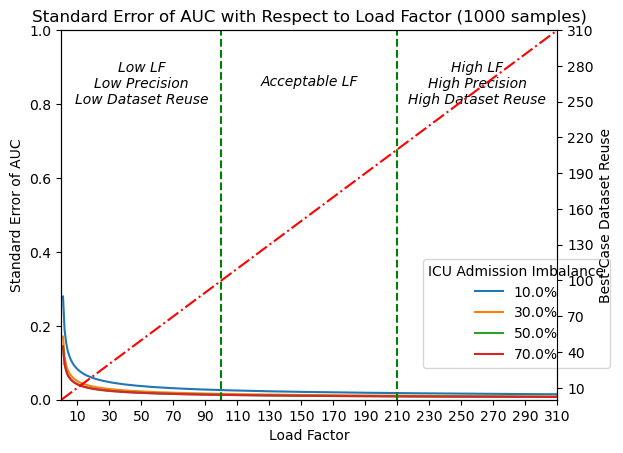

In [65]:
# Multiple Line Plots
df = pd.read_excel("exampleOutputMIDRC.xlsx")
eval_res = df["result"]
pred_rate = df["predictionR"]
fpr,tpr,thresholds = metrics.roc_curve(eval_res,pred_rate)
auc = metrics.auc(fpr,tpr)
lfs = np.arange(1,320,1)
numsamps = int(input("Number of samples: "))
ICU_imbs = np.arange(0.1,0.9,0.2)
#ICU_imbs = np.insert(ICU_imbs, 0, 0.05)
info = determineLoadFactors(numsamps, len(df), lfs)
ssize_arr = info[0]
actual_lfs = info[1]
stDev_AUCs = []
for i,_ in enumerate(ICU_imbs):
    stDev_AUCs.append([])
    for j,_ in enumerate(ssize_arr):
        stDev_AUCs[-1].append(calcAUCstDev(auc, actual_lfs[j], len(df), numsamps, ICU_imbs[i]))
fig, ax = plt.subplots()
for i,stDev_AUC in enumerate(stDev_AUCs):
    plt.plot(lfs, stDev_AUC, label = str(round(ICU_imbs[i] * 100, 1)) + "%")
plt.ylim([0,1])
plt.xticks(np.arange(10,320,20))
plt.xlim([0,310])
plt.ylabel("Standard Error of AUC")
plt.xlabel("Load Factor")
plt.title("Standard Error of AUC with Respect to Load Factor (1000 samples)")
plt.axvline(100, linestyle = "--", color = "green")
plt.axvline(210, linestyle = "--", color = "green")
plt.text(50, 0.8, "Low LF\nLow Precision\nLow Dataset Reuse", ha = "center", style = "italic")
plt.text(155, 0.85, "Acceptable LF", ha = "center", style = "italic")
plt.text(260, 0.8, "High LF\nHigh Precision\nHigh Dataset Reuse", ha = "center", style = "italic")
plt.legend(title = "ICU Admission Imbalance", bbox_to_anchor = (1.12,0.4))
ax2 = plt.twinx()
lower_y,upper_y = ax.get_ylim()
ax2.set_ylim(lower_y, upper_y)
ax2.set_yticks(np.arange(10,320,30))
ax2.plot([0.0,310], [0.0,310], color = "red", linestyle = "-.")
ax2.set_ylabel("Best-Case Dataset Reuse")
plt.show()